## Notebook for dataset preparation


For the dataset the Polish youth slang will be used: https://huggingface.co/datasets/jziebura/polish_youth_slang_classification


**sentiment:**
- 0 - negative
- 1 - neutral
- 2 - positive

### Imports

In [1]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer

In [2]:
dataset = load_dataset("jziebura/polish_youth_slang_classification", cache_dir="./data")
train_df = dataset["train"].to_pandas()
val_df = dataset["validation"].to_pandas()
test_df = dataset["test"].to_pandas()


print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 4337
Validation set size: 542
Test set size: 543


Only columns that will be needed are:
- "słowo slangowe"
- "znaczenie"
- "tekst"
- "sentyment"

In [3]:
column_mapping = {
    "słowo slangowe": "word",
    "znaczenie wyrazów slangowych": "meaning",
    "tekst": "text",
    "sentyment": "label",
}


train_df = train_df.drop(columns=["źródło", "powiązana data"])
val_df = val_df.drop(columns=["źródło", "powiązana data"])
test_df = test_df.drop(columns=["źródło", "powiązana data"])

train_df = train_df.rename(columns=column_mapping)
val_df = val_df.rename(columns=column_mapping)
test_df = test_df.rename(columns=column_mapping)

## Data processing and analysis

In [4]:
train_df.head(5)

,word,meaning,text,label
0,Furta,Pogardliwe określenie na szerokiego kolegę. Za...,"- Masz może lejsy, Damian? - Mam, ale ci nie ...",0
1,rzucać buchem,handlować marihuaną,"- Siema mordo, skąd Gucio ma kase na te marko...",1
2,Chędożony,Przymiotnik używany w celu podkreśleniu emocji...,Gówniarz chędożony! Jak nie masz gdzie palcy ...,0
3,Jebnik,"niewyobrażalny brud, syf, bałagan. Synonim sło...",- Zaraz wszystko z blatu w kuchni wyląduje w ...,0
4,Baka!,"Po japońsku ""głupek"". Używane (często żartobli...",Baka!,0


### 1. None values


In [5]:
missing_train = train_df.isna().sum()
print("Na values train_df:")
print(missing_train)

Na values train_df:
word       0
meaning    1
text       0
label      0
dtype: int64


In [6]:
missing_rows = train_df[train_df["meaning"].isna()]
print(missing_rows)

                word meaning                                 text  label
158  niepełnosprytny    None  Kurde on jest jakiś niepełnosprytny      0


In [7]:
train_df.loc[train_df["meaning"].isna(), "meaning"] = (
    "Osoba, która jest głupia i niezdarna w swoich działaniach"
)


In [8]:
missing_train = train_df.isna().sum()
print("Na values train_df:")
print(missing_train)

Na values train_df:
word       0
meaning    0
text       0
label      0
dtype: int64


### 2. Labels distribition

<Axes: title={'center': 'Labels distribution in train set'}, xlabel='label'>

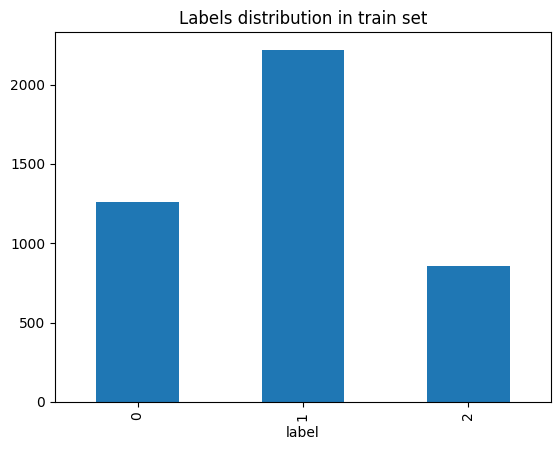

In [9]:
train_df["label"].value_counts().sort_index().plot.bar(
    title="Labels distribution in train set"
)

### 3, Duplicates

In [10]:
num_duplicates = train_df.duplicated(subset=["text", "word"]).sum()
print(f"Duplicates in text and slang_word: {num_duplicates}")

Duplicates in text and slang_word: 1


In [11]:
train_df = train_df.drop_duplicates(subset=["text", "word"], keep="first")

In [12]:
print(f"Train set size after removing duplicates: {len(train_df)}")

Train set size after removing duplicates: 4336


### 4. Length distribiution

Length distribiution, but counted in tokens

In [17]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")

Token indices sequence length is longer than the specified maximum sequence length for this model (597 > 512). Running this sequence through the model will result in indexing errors


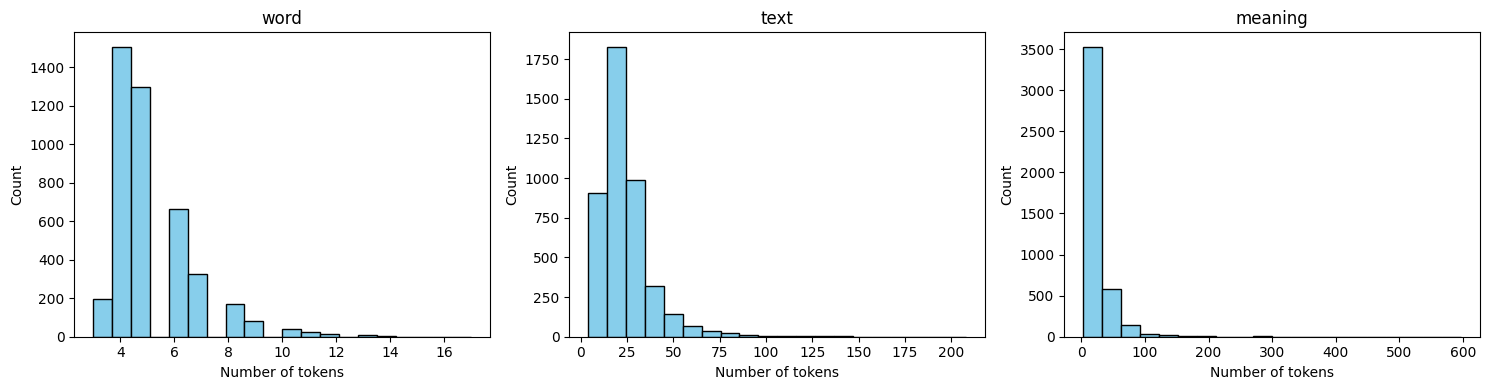

In [18]:
import matplotlib.pyplot as plt

columns = ["word", "text", "meaning"]

fig, axes = plt.subplots(1, len(columns), figsize=(15, 4))

for i, col in enumerate(columns):
    lengths = [
        len(tokenizer.encode(str(x), add_special_tokens=True)) for x in train_df[col]
    ]

    axes[i].hist(lengths, bins=20, color="skyblue", edgecolor="black")
    axes[i].set_title(col)
    axes[i].set_xlabel("Number of tokens")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

Seq_len of 128 should be definitelly enough for the model.

In [19]:
train_df.to_csv("./prepared_data/train.csv", index=False)
test_df.to_csv("./prepared_data/test.csv", index=False)
val_df.to_csv("./prepared_data/val.csv", index=False)